<h1> <a> Introduction  </a> </h1>

# Sentiment Analysis with an RNN

you'll implement a recurrent neural network that performs sentiment analysis. 
>Using an RNN rather than a strictly feedforward network is more accurate since we can include information about the *sequence* of words. 

Here we'll use a dataset of electronics reviews, accompanied by sentiment labels: positive, negative or neutral.

<img align="middle" src="https://th.bing.com/th/id/OIP.ga-SiZtiielm5ovfr9b2jAHaFj?pid=ImgDet&rs=1" width="600" height="300">

### Network Architecture

The architecture for this network is shown below.

<img align="middle" src="https://th.bing.com/th/id/R186da34c5bacad0287a83c0b0b8683b7?rik=hlrz7baAq3AUow&pid=ImgRaw" width="600" height="300">

>**First, we'll pass in words to an embedding layer.** We need an embedding layer because we have tens of thousands of words, so we'll need a more efficient representation for our input data than one-hot encoded vectors. You should have seen this before from the Word2Vec lesson. You can actually train an embedding with the Skip-gram Word2Vec model and use those embeddings as input, here. However, it's good enough to just have an embedding layer and let the network learn a different embedding table on its own. *In this case, the embedding layer is for dimensionality reduction, rather than for learning semantic representations.*

>**After input words are passed to an embedding layer, the new embeddings will be passed to LSTM cells.** The LSTM cells will add *recurrent* connections to the network and give us the ability to include information about the *sequence* of words in the movie review data. 

>**Finally, the LSTM outputs will go to a softmax output layer.** We're using a softmax function 


<h1 color ='red'> <a> Table of contents </a> </h1>

*           <h1> <a>Getting Dataset  </a> </h1>
*           <h1> <a>Data Exploration  </a> </h1>
*           <h1> <a>Data Analysis  </a> </h1>
*           <h1> <a> implement word Embeddings </a> </h1>
*           <h1> <a> Visualize word meanings  </a> </h1>

*           <h1> <a> Apply Deep learning model (Lstm)  </a> </h1>
*           <h1> <a> Test models   </a> </h1>
*           <h1> <a> Deploy model   </a> </h1>
*           <h1> <a> Summary    </a> </h1>



*  <h1> <a href = "http://jmcauley.ucsd.edu/data/amazon/" > Link Dataset </a> </h1>


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install gensim==3.8.0

<h1> <a> import Library </a> </h1>

In [ ]:
# DataFrame

import pandas as pd
import tensorflow as tf
# Matplot
import matplotlib.pyplot as plt
%matplotlib inline
import math

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.callbacks import LearningRateScheduler
# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools


In [ ]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 128
W2V_WINDOW = 10
W2V_EPOCH = 256
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 10
BATCH_SIZE = 64


# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.pkl"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/sentiment_analysis_dataset/Electronics_5.csv')

## <a> Data Exploration </a> 

In [ ]:
df.head(3)

,Unnamed: 0,overall,reviewText,target
0,0,5,We got this GPS for my husband who is an (OTR)...,pos
1,1,1,"I'm a professional OTR truck driver, and I bou...",neg
2,2,3,"Well, what can I say. I've had this unit in m...",natural


In [ ]:
df.shape

(1689188, 4)

In [ ]:
df.columns

Index(['Unnamed: 0', 'overall', 'reviewText', 'target'], dtype='object')

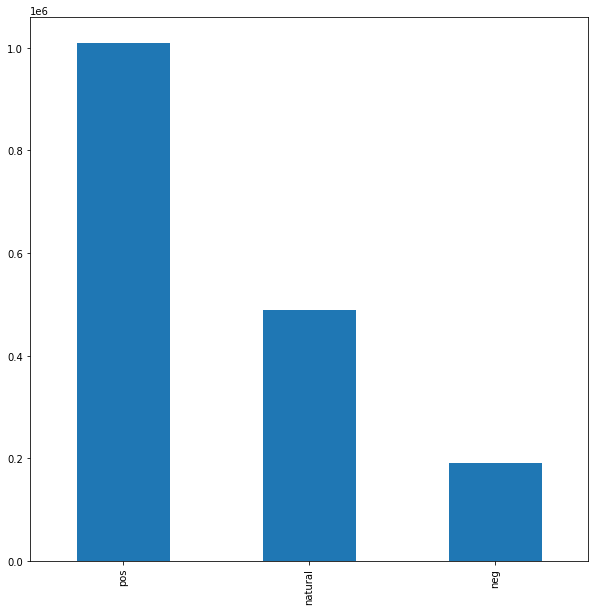

In [ ]:
## draw output of target value 
 
plt.figure(figsize = (10 ,10))
df.target.value_counts().plot(kind = 'bar')

In [ ]:
## count output target in Dataset 
df.target.value_counts()

pos        1009026
natural     489298
neg         190864
Name: target, dtype: int64

In [ ]:
df.overall.value_counts()

5    1009026
4     347041
3     142257
1     108725
2      82139
Name: overall, dtype: int64

In [ ]:
df.isnull().sum()

Unnamed: 0       0
overall          0
reviewText    1071
target           0
dtype: int64

## <a> Data Cleaning </a>

## 1.<a> drop null value  <a/>

In [ ]:
df.dropna(axis = 0 , inplace=True)
df.isnull().sum()

Unnamed: 0    0
overall       0
reviewText    0
target        0
dtype: int64

In [ ]:
df.shape

(1688117, 4)

## <a> drop unnecessary column </a>

In [ ]:
df = df.drop(['Unnamed: 0' , 'overall'] , axis = 1)

In [ ]:
df.columns

Index(['reviewText', 'target'], dtype='object')

In [ ]:
df.head(2)

,reviewText,target
0,We got this GPS for my husband who is an (OTR)...,pos
1,"I'm a professional OTR truck driver, and I bou...",neg


## <a> Handle implanced data for each category </a> 

In [ ]:
df1 = df[df['target'] == 'pos'][:3000]
df2 = df[df['target'] == 'natural'][:3000]
df3 = df[df['target'] == 'neg'][:3000]


In [ ]:
df = df1.append([df2 ,df3 ] , sort = True )

In [ ]:
# shuffle the DataFrame rows
df = df.sample(frac = 1)

Text(0, 0.5, 'count each category ')

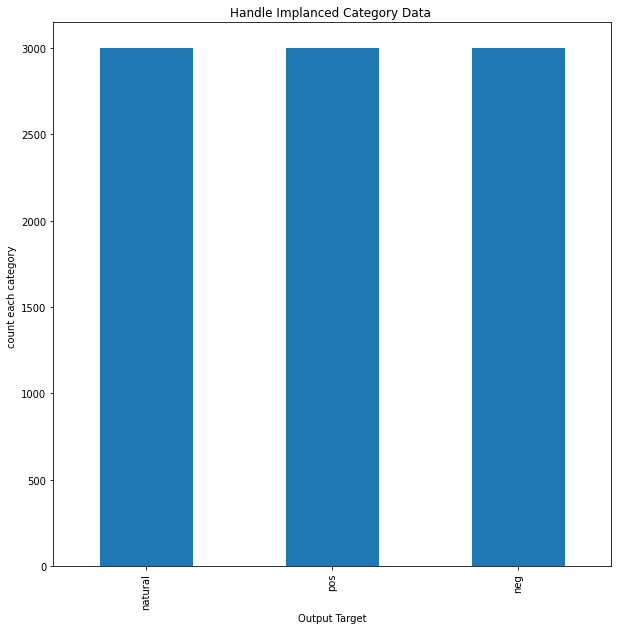

In [ ]:
## draw output of target value 

plt.figure(figsize = (10 ,10))
df.target.value_counts().plot(kind = 'bar')
plt.title('Handle Implanced Category Data ')
plt.xlabel('Output Target') 
plt.ylabel('count each category ') 

In [ ]:
df.target.value_counts()

natural    3000
pos        3000
neg        3000
Name: target, dtype: int64

## <a> 1. Remove Stop words </a> 

## <a> 2. Remove special character  </a> 

In [ ]:

## download stopwords 
stop_words = stopwords.words("english")
## download steaming 
stemmer = SnowballStemmer("english")

## reg for remove special character 
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"


"""
  preprocess function 

  input  : each row from data 

  output : text cleaning 

"""
def preprocess_text(text , stem =False):
  # Remove link,user and special characters
  text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
  text = re.sub(r'[0-9]+', '', text)
  tokens = []
  for token in text.split():
    if token not in stop_words and len(token) >2:

      tokens.append(token)
  return " ".join(tokens)

In [ ]:
df.reviewText = df.reviewText.apply(lambda x: preprocess_text(x))


## <a> Save Clean Text </a>

In [ ]:
df.to_csv('clean_data.csv')

## <a> Upload Clean Data on Curl </a> 

In [ ]:
#!wget https://transfer.sh/1xhQPpb/clean_data.csv

In [ ]:
df.reviewText[1]

'professional otr truck driver bought tnd truck stop hoping make life easier rand mcnally listening first thing charging connect laptop install software attempt update software detected problem update wanted home address could sent patch card hello think unusual home address box friend checks weekly might get check every six months live truck truck stops need make patch available card send cards truck stops devices sold ran update program multiple times program said tnd completely updated programmed height length weight rig told preferred highways parked truck stop cincinnati area next pickup miles freeway side couple blocks cell phone gps sprint said get freeway get pickup tnd routed thru miles residential streets finally getting pickup exciting especially since every time refused turn street posted trucks tnd took almost minutes figure route happened multiple times short trip decided give another chance pickup north side cincinnati needed head phoenix via easy route hop drive west so

In [ ]:
df.target[1]

'neg'

In [ ]:
## convert output target to one hot encoder 

y = pd.get_dummies(df.target)

x = df.drop('target' , axis =1 )

In [ ]:
y.columns

Index(['natural', 'neg', 'pos'], dtype='object')

In [ ]:
x[:3]

,reviewText
4005,comfortable sturdy decent sound certainly woul...
6079,running phone line behind stereo cabinet could...
6816,appears work advertised currently used connect...


## <a> Split Dataset into [training - testing - validation]  </a>

In [ ]:
X_train,X_test, y_train,y_test= train_test_split(x,y, test_size=0.2, random_state=42 , shuffle = True)
X_test,X_valid, y_test,y_valid= train_test_split(X_test,y_test, test_size=0.5, random_state=42 , shuffle = True)

## print output shape
print("X_train size:", X_train.shape)
print("y_train size:", y_train.shape)
print("X_test size:", X_test.shape)
print("y_test size:", y_test.shape)
print("X_valid size:", X_valid.shape)
print("y_valid size:", y_valid.shape)

X_train size: (7200, 1)
y_train size: (7200, 3)
X_test size: (900, 1)
y_test size: (900, 3)
X_valid size: (900, 1)
y_valid size: (900, 3)


## <a> build vocabulary from train dataset </a>

In [ ]:
#documents = [_text.split() for _text in X_train.reviewText]


In [ ]:
#w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
#                                            window=W2V_WINDOW, 
#                                            min_count=W2V_MIN_COUNT, 
#                                            workers=8)

In [ ]:
#w2v_model.build_vocab(documents)


In [ ]:
#words = w2v_model.wv.vocab.keys()
#vocab_size = len(words)
#print("Vocab size", vocab_size)

In [ ]:
#w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)


In [ ]:
#w2v_model.save('w2vec.pkl')

## <a> Upload word2vec model on curl  </a>

In [ ]:
!wget https://transfer.sh/1R9UsvH/w2vec.pkl

--2021-06-17 20:39:21--  https://transfer.sh/1R9UsvH/w2vec.pkl
Resolving transfer.sh (transfer.sh)... 144.76.136.153
Connecting to transfer.sh (transfer.sh)|144.76.136.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26562578 (25M) []
Saving to: ‘w2vec.pkl.1’

w2vec.pkl.1         100%[===================>]  25.33M  14.3MB/s    in 1.8s    

2021-06-17 20:39:24 (14.3 MB/s) - ‘w2vec.pkl.1’ saved [26562578/26562578]



In [ ]:
with open('/content/w2vec.pkl', 'rb') as f:
  w2v_model = pickle.load(f)

In [ ]:
w2v_model.most_similar("good")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('decent', 0.8462110161781311),
 ('great', 0.7545416951179504),
 ('excellent', 0.7314164042472839),
 ('fantastic', 0.6389633417129517),
 ('exceptional', 0.6380005478858948),
 ('nice', 0.59938645362854),
 ('reasonable', 0.5827001333236694),
 ('impressive', 0.581800103187561),
 ('terrific', 0.5753396153450012),
 ('awesome', 0.5731416344642639)]

In [ ]:
w2v_model.most_similar("bad")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('terrible', 0.6275604367256165),
 ('horrible', 0.6093299388885498),
 ('poor', 0.6064659357070923),
 ('lousy', 0.6006596088409424),
 ('awful', 0.5818268060684204),
 ('lemon', 0.536183774471283),
 ('defective', 0.5345633029937744),
 ('faulty', 0.533707320690155),
 ('dud', 0.5212666988372803),
 ('crappy', 0.5008470416069031)]

## <a> Import Word2vec model  </a>

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train.reviewText)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 19756


In [ ]:
#tokenizer.save('tokenizer.pkl')

In [ ]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train.reviewText), maxlen=SEQUENCE_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test.reviewText), maxlen=SEQUENCE_LENGTH)

In [ ]:
print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("x_test", X_test.shape)
print("y_test", y_test.shape)

x_train (7200, 300)
y_train (7200, 3)
x_test (900, 300)
y_test (900, 3)


## <a> Tokenize Data </a>

In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    
    if word in w2v_model.wv:
        
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(19756, 128)


In [ ]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)


## <a> build Model </a> 

In [ ]:
from keras.layers import BatchNormalization,Input,TimeDistributed,Bidirectional
from keras.models import Model,Sequential
from keras.layers import GRU, Input, Dense,SpatialDropout1D , TimeDistributed, Activation, RepeatVector, Bidirectional,LSTM
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
import pickle
from keras.layers.pooling import GlobalPooling1D
from keras.layers import GlobalMaxPool1D


In [ ]:
def step_decay(epoch):
	initial_lrate = 0.01
	drop = 0.3
	epochs_drop = 10.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

In [ ]:

def lstm_model():
  model = Sequential()
  model.add(Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False))
  model.add(LSTM( 64, recurrent_dropout=0.1 ,  return_sequences=True ))
  model.add((LSTM(64,recurrent_dropout=0.2,  return_sequences=False )))
  model.add( Dense(3, activation = 'softmax'))
  print(model.summary())
  return model




In [ ]:
model = lstm_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 128)          2528768   
_________________________________________________________________
lstm (LSTM)                  (None, 300, 64)           49408     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
Total params: 2,611,395
Trainable params: 82,627
Non-trainable params: 2,528,768
_________________________________________________________________
None


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy'])

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)
             # LearningRateScheduler(step_decay)
             ]

In [ ]:
history = model.fit(X_train, y_train,
                      batch_size=32,
                      epochs=6,
                      verbose=1,
                    #  callbacks=callbacks,
                      workers=4
                    )

Epoch 1/6
225/225 [==============================] - 159s 578ms/step - loss: 0.9337 - accuracy: 0.5355
Epoch 2/6
225/225 [==============================] - 130s 579ms/step - loss: 0.6763 - accuracy: 0.7064
Epoch 3/6
225/225 [==============================] - 130s 577ms/step - loss: 0.5587 - accuracy: 0.7698
Epoch 4/6
225/225 [==============================] - 130s 579ms/step - loss: 0.4604 - accuracy: 0.8127
Epoch 5/6
225/225 [==============================] - 133s 590ms/step - loss: 0.3486 - accuracy: 0.8745
Epoch 6/6
225/225 [==============================] - 129s 574ms/step - loss: 0.2284 - accuracy: 0.9197


## <a> Save model </a>

In [ ]:
model.save('model.h5')

In [ ]:
score = model.evaluate(X_train , y_train, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

113/113 [==============================] - 16s 146ms/step - loss: 0.1675 - accuracy: 0.9489

ACCURACY: 0.948888897895813
LOSS: 0.16746142506599426


In [ ]:
score = model.evaluate(X_test , y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

15/15 [==============================] - 4s 159ms/step - loss: 1.0827 - accuracy: 0.6322

ACCURACY: 0.6322222352027893
LOSS: 1.0827151536941528


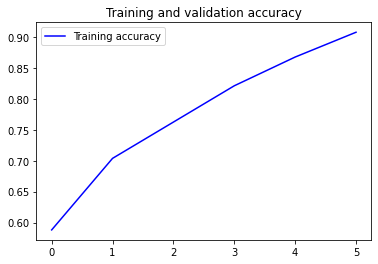

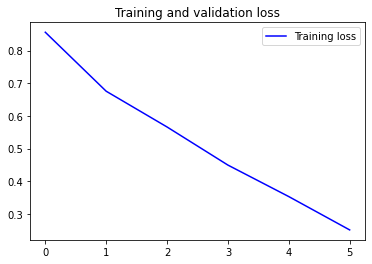

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
#plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

## <a> predict sentence </a>

In [ ]:
target = y.columns

In [ ]:
target[0]

'natural'

In [ ]:
def predict(text):

  # Tokenize text
  x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
  
  # Predict
  score = model.predict([x_test])[0]

  return target[np.argmax(score)]

In [ ]:
text ="professional otr truck driver bought tnd truck stop hoping make life easier rand mcnally listening first thing charging connect laptop install software attempt update software detected problem update wanted home address could sent patch card hello think unusual home address box friend checks weekly might get check every six months live truck truck stops need make patch available card send cards truck stops devices sold ran update program multiple times program said tnd completely updated programmed height length weight rig told preferred highways parked truck stop cincinnati area next pickup miles freeway side couple blocks cell phone gps sprint said get freeway get pickup tnd routed thru miles residential streets finally getting pickup exciting especially since every time refused turn street posted trucks tnd took almost minutes figure route happened multiple times short trip decided give another chance pickup north side cincinnati needed head phoenix via easy route hop drive west south intersection indeed cell phone advised tnd however wanted route surface streets across city pick side city turned next time passed truck stop chain purchased returned got money back spent cheap printer take minute set route google print gotten lost yet several cross country trips"
predict(text)

'neg'

In [ ]:
text ="quality of this electronics is good"
predict(text)

'pos'

In [ ]:
text ="quality of this electronics has defects"
predict(text)

'neg'